In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
#import ROOT as r
import time
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
#%jsroot on

In [2]:
def fit(nsamples,nbins,start): #define starting index
    cols=[f'toybin{i:04d}' for i in range(start,start+nbins)]
    diagnostics_df=pd.DataFrame(columns=cols,index=['sigma_median','mcse','rhat'])
    sigma_df=pd.DataFrame(columns=cols)
    for i in range(start,start+nbins):#no. of toy bins
        #read data
        df=pd.read_csv(f"toybins/toybin{i:04d}.txt",sep="\t")
        #df=pd.read_csv(f"new_toy_MC.txt",sep="\t")
        df.columns=['pol','phi','weight']
        #these are prompt peak events
        prmpt=df.loc[df['weight']==1]
        prmpt=prmpt.reset_index(drop=True)
        #sideband
        side=df.loc[df['weight']!=1]
        side=side.reset_index(drop=True)
        nprmpt=len(prmpt)
        total_nside=(len(side))
        #weights used in the data, including 1--> exterminate 1
        weights=pd.unique(df['weight'].values)
        weights=np.array(weights[weights!=1])
        #sideband events are identified by the corresponding weights
        nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
        #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
        f=(nprmpt+np.sum(nside*weights))/nprmpt
        print(f)
        stan_data={
            'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
            'phi_prmpt':list(prmpt['phi'].values),
            'pol_prmpt':list(prmpt['pol'].values),
            'M':total_nside,#no. of sideband events and..
            'phi_side':list(side['phi'].values),
            'pol_side':list(side['pol'].values),
            'f':f #fraction of signal in prmpt peak
        }
        print(nprmpt, total_nside)
        #now the stan model and mcmc
        model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
        model.compile()
        fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0)
        summary=fitobj.summary()
        samples=fitobj.draws_pd()
        #get mcmc diagnostics
        median=summary['50%']['sigma']
        mcse=(az.mcse(np.transpose(fitobj.draws(concat_chains=False)[:,:,7]),method='median'))
        rhat=(summary['R_hat']['sigma'])
        tmp_list=[median,mcse,rhat]
        currbin=f"toybin{i:04d}"
        diagnostics_df[currbin]=tmp_list
        sigma_df[currbin]=samples['sigma']
    return diagnostics_df, sigma_df, summary

In [3]:
dfs=fit(nsamples=1000,nbins=100,start=100)
diagnostics=dfs[0]
sigma=dfs[1]
diagnostics.to_csv('toy_diagnostics_01.csv')
sigma.to_csv('toy_sigma_01.csv')

0.9498084448823207
1827 2397


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

ERROR:cmdstanpy:Chain [2] error: terminated by signal 2 Unknown error: -2
ERROR:cmdstanpy:Chain [3] error: terminated by signal 2 Unknown error: -2
ERROR:cmdstanpy:Chain [1] error: terminated by signal 2 Unknown error: -2
ERROR:cmdstanpy:Chain [4] error: terminated by signal 2 Unknown error: -2


KeyboardInterrupt: 

In [2]:
sigma_df=pd.read_csv('toy_sigma_00.csv',index_col=0)
diagnostics_df=pd.read_csv('toy_diagnostics_00.csv',index_col=0)

In [7]:
sigma_df.columns=[f"toybin{i:04d}" for i in range(100)]
sigma_df.to_csv('toy_sigma_00.csv')
sigma_df

,toybin0000,toybin0001,toybin0002,toybin0003,toybin0004,toybin0005,toybin0006,toybin0007,toybin0008,toybin0009,...,toybin0090,toybin0091,toybin0092,toybin0093,toybin0094,toybin0095,toybin0096,toybin0097,toybin0098,toybin0099
0,0.360474,0.520004,0.558932,0.271299,0.594258,0.277294,0.271048,0.476488,0.598589,0.392830,...,0.708033,0.479800,0.528413,0.599336,0.417573,0.387373,0.689200,0.514006,0.452625,0.636630
1,0.812229,0.772097,0.394815,0.412408,0.333986,0.910872,0.615818,0.515271,0.273188,0.208677,...,0.528150,0.426806,0.322815,0.584971,0.245142,0.373919,0.706423,0.594741,0.336895,0.717322
2,0.490239,0.628934,0.473349,0.239877,0.327644,0.716130,0.320117,0.511273,0.473130,0.488554,...,0.696145,0.381953,0.697167,0.596623,0.171891,0.540057,0.731722,0.617024,0.465945,0.789376
3,0.664927,0.546067,0.580071,0.534017,0.553835,0.723876,0.625633,0.604395,0.546800,0.382058,...,0.778252,0.398473,0.344007,0.728617,0.408151,0.614683,0.758602,0.808530,0.435860,0.594533
4,0.800506,0.576375,0.536654,0.157497,0.456061,0.612207,0.283734,0.663216,0.565594,0.405988,...,0.777286,0.280531,0.429639,0.525282,0.480483,0.537231,0.777178,0.472939,0.333710,0.759636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.481856,0.565920,0.568319,0.354533,0.490155,0.610725,0.303198,0.464219,0.439868,0.266718,...,0.527598,0.323552,0.314936,0.606926,0.363377,0.832110,0.605518,0.523535,0.503233,0.841386
3996,0.701961,0.475407,0.725140,0.295788,0.359417,0.648399,0.723854,0.732398,0.582047,0.283119,...,0.644648,0.430570,0.648150,0.587556,0.357045,0.414428,0.750755,0.621726,0.314549,0.928250
3997,0.531829,0.650893,0.634416,0.244964,0.509931,0.690249,0.586700,0.536041,0.613698,0.304373,...,0.489148,0.319616,0.262793,0.684723,0.397064,0.587948,0.681838,0.723986,0.242769,0.422314
3998,0.472321,0.329724,0.410684,0.407058,0.606131,0.487202,0.346381,0.552047,0.262649,0.210460,...,0.525198,0.410893,0.775302,0.584600,0.229534,0.482001,0.573217,0.454726,0.600653,0.988487


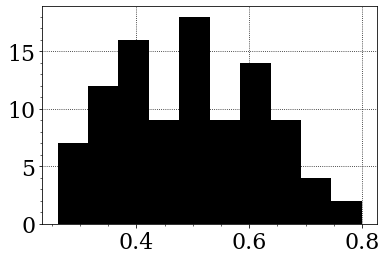

In [4]:

medians=[(diagnostics_df[f'toybin{i:04d}']['sigma_median']) for i in range(100)]
plt.hist(medians)
plt.show()

In [5]:
all_sigmas=[]
for i in range(100):
    all_sigmas.extend((np.array(sigma_df[f'toybin{i:04d}'].values)-0.5))

In [6]:
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
mu=np.mean(all_sigmas)
sigma=np.std(all_sigmas)

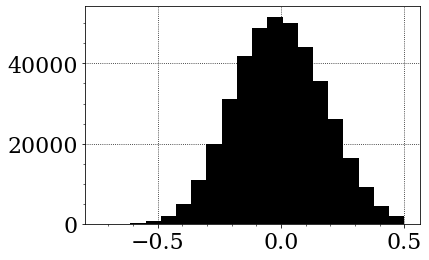

In [7]:
plt.hist(all_sigmas,bins=20)
plt.show()

In [8]:
h=r.TH1D("h","h",100,-5,5)
for i in range(len(all_sigmas)):
    h.Fill(all_sigmas[i])
    

In [9]:
c=r.TCanvas()
c.Draw("")
h.Draw("")
h.Fit("gaus")

 FCN=1904.77 FROM MIGRAD    STATUS=CONVERGED      68 CALLS          69 TOTAL
                     EDM=7.59113e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     8.73799e+04   1.64864e+02   2.95121e+00   2.88910e-08
   2  Mean        -3.05018e-03   2.99389e-04   6.22882e-06   1.13561e-01
   3  Sigma        1.82228e-01   1.91456e-04   6.16767e-06  -7.06559e-02
/usr/include/c++/11.2.0/bits/shared_ptr_base.h:979: std::__shared_ptr_access<_Tp, _Lp, <anonymous>, <anonymous> >::element_type& std::__shared_ptr_access<_Tp, _Lp, <anonymous>, <anonymous> >::operator*() const [with _Tp = TFitResult; __gnu_cxx::_Lock_policy _Lp = __gnu_cxx::_S_atomic; bool <anonymous> = false; bool <anonymous> = false; std::__shared_ptr_access<_Tp, _Lp, <anonymous>, <anonymous> >::element_type = TFitResult]: Assertion '_M_get() != nullptr' failed.
/usr/includ

Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
 *** Break *** abort
 Generating stack trace...
 0x00007f0ddc16e4b8 in raise at :? from /usr/lib/libc.so.6
 0x00007f0ddc158534 in abort at :? from /usr/lib/libc.so.6
 0x00007f0d742640be in TFitResultPtr::operator*() const + 0x5e from /usr/lib/root/libHist.so
 0x00007f0d751ba024 in <unknown function>
 0x00007f0d87774f47 in <unknown> from /usr/lib/root/libcppyy_backend3_10.so
 0x00007f0d87776534 in Cppyy::CallR(long, void*, unsigned long, void*) + 0x34 from /usr/lib/root/libcppyy_backend3_10.so
 0x00007f0d878389e4 in <unknown> from /usr/lib/python3.10/site-packages/libcppyy3_10.so
 0x00007f0d8781e2a6 in <unknown> from /usr/lib/python3.10/site-packages/libcppyy3_10.so
 0x00007f0d87820dc0 in CPyCppyy::CPPMethod::ExecuteProtected(void*, long, CPyCppyy::CallContext*) + 0x120 from /usr/lib/python3.10/site-packages/libcppyy3_10.so
 0x00007f0d8781f4ef in CPyCppyy::CPPMethod::Execute(void*, long, CPyCppyy::CallContext*) + 0x2f 

In [1]:
for i in range(100,100+100):
    print(i)

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
